In [4]:
from dataset import TrajectoryDataset, gtppo_collate
import torch
from tqdm import tqdm
# visualize the rotated trajectory
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# set figure size
plt.rcParams['figure.figsize'] = (12.8, 7.2)

In [5]:
%load_ext autoreload 
%autoreload 2

## read data

In [6]:
file_path = "data/ethucy_sgan/raw/all_data"
dataset = TrajectoryDataset(file_path, obs_len=8, pred_len=12, skip=1, use_prepared_data=True)
obs_trajs = dataset.obs_traj # (N, 2, obs_len)
pred_trajs = dataset.pred_traj # (N, 2, pred_len)
seq_start_end = dataset.seq_start_end # (N * 2)
print("data num: ", len(dataset))

data num:  3590


# Rotation

In [7]:
# get velocity direction
last_step_vel = obs_trajs[:, :, -1] - obs_trajs[:, :, -2] # (N, 2)
theta = torch.atan2(last_step_vel[:, 1], last_step_vel[:, 0]) # angle between x-axis and velocity direction (N,)

# get rotation matrix
theta = theta.unsqueeze(1).unsqueeze(2) # (N, 1, 1)
rotation_matrix = torch.cat([torch.cos(theta), torch.sin(theta), -torch.sin(theta), torch.cos(theta)], dim=1) 
rotation_matrix = rotation_matrix.reshape(-1, 2, 2) # (N, 2, 2)

# rotate the obs trajectory
center = obs_trajs[:, :, -1:].clone() # (N, 2, 1)
obs_trajs_rot = (obs_trajs - center) # (N, 2, obs_len)
print("obs_trajs_rot: ", obs_trajs_rot.shape)
print("rotation_matrix: ", rotation_matrix.shape)
obs_trajs_rot = torch.matmul(rotation_matrix, obs_trajs_rot) # (N, 2, obs_len)

# evaluate the rotation
last_step_vel_rot = obs_trajs_rot[:, :, -1] - obs_trajs_rot[:, :, -2] # (N, 2)
last_step_vel_rot = last_step_vel_rot # (N, 2)
theta_rot = torch.atan2(last_step_vel_rot[:, 1], last_step_vel_rot[:, 0]) # angle between x-axis and velocity direction (N,)
print("assert theta_rot: ", torch.allclose(theta_rot, torch.zeros_like(theta_rot), atol=1e-5)) # theta_rot should be zero, i.e. the last step velocity direction should be x-axis
print("assert last_step_vel_rot: ", torch.allclose(last_step_vel_rot[:,1], torch.zeros_like(last_step_vel_rot[:,1]), atol=1e-5)) # vel_y should be zero

obs_trajs_rot:  torch.Size([36497, 2, 8])
rotation_matrix:  torch.Size([36497, 2, 2])
assert theta_rot:  True
assert last_step_vel_rot:  True


In [8]:
# rotate the pred trajectory
pred_trajs_rot = (pred_trajs - center) # (N, 2, pred_len)
pred_trajs_rot = torch.matmul(rotation_matrix, pred_trajs_rot) # (N, 2, pred_len)


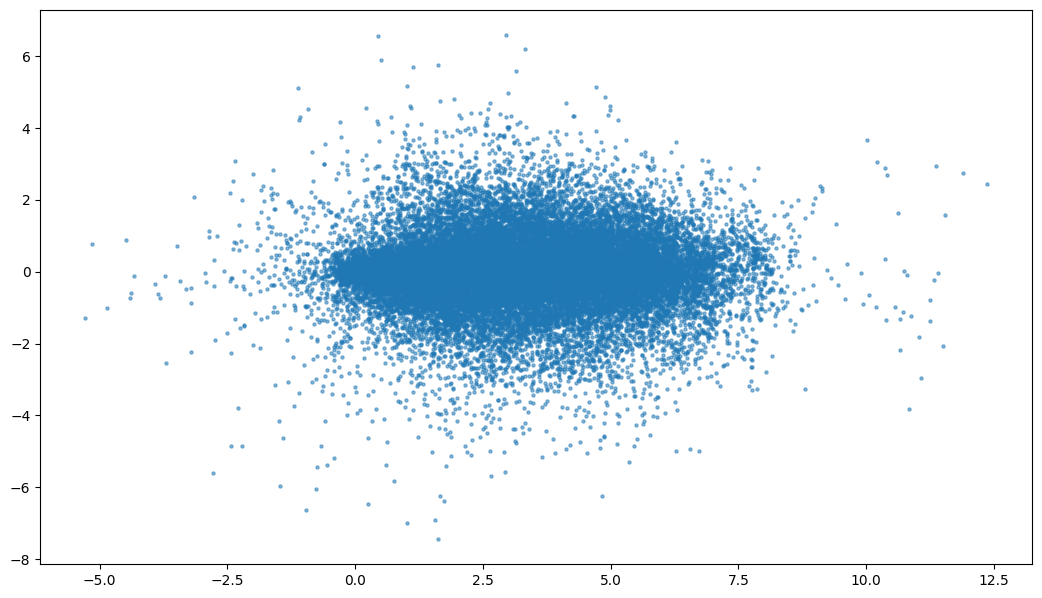

In [9]:


# set figure size
plt.rcParams['figure.figsize'] = (12.8, 7.2)
colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # 红、黄、绿三种颜色
cmap_name = 'my_list'
n_bins = 1000  # 颜色梯度的数量
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# plot the rotated obs trajectory, green is the last step, red is the first step
# for i,traj in enumerate(tqdm(pred_trajs_rot)):
#     plt.scatter(traj[0], traj[1], c=np.arange(12), cmap=cmap, s=5)
plt.scatter(pred_trajs_rot[:,0,-1], pred_trajs_rot[:,1,-1],s=5,alpha=0.5)
plt.show()



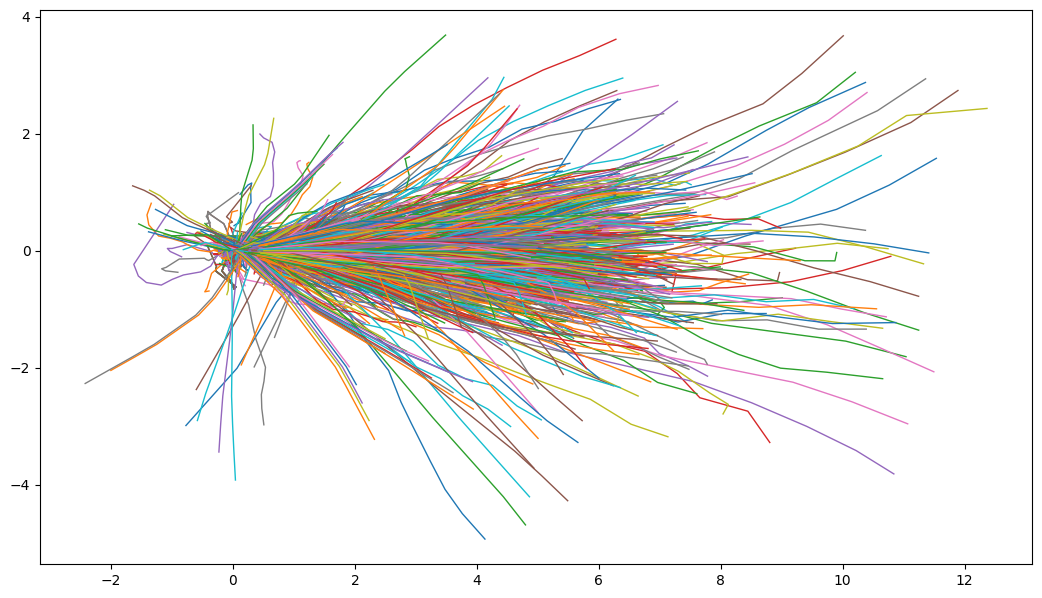

In [7]:
# for i,traj in enumerate(tqdm(trajs)):
#     plt.plot(traj[0], traj[1], linewidth=1)
plt.plot(pred_trajs_rot[:2000,0,:].T, pred_trajs_rot[:2000,1,:].T, linewidth=1)
plt.show()

# Cluster Cop Kmeans

In [13]:
sampled_trajs = pred_trajs_rot

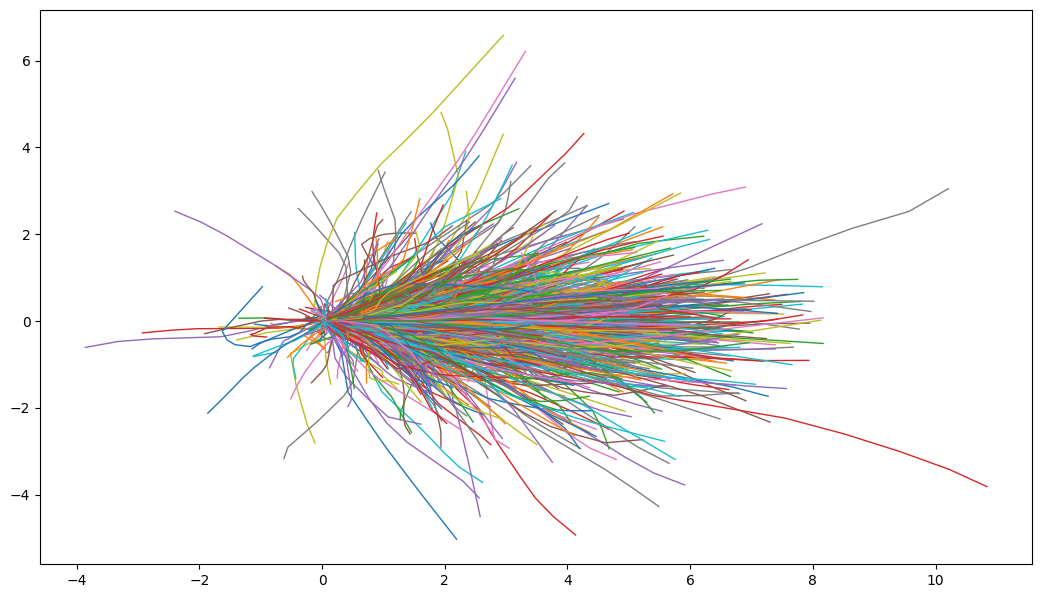

In [8]:
# randomly sample 2000 trajectories from pred_trajs_rot
import random
import time
random.seed(time.time())
sampled_id = random.sample(range(len(pred_trajs_rot)), 2000)
sampled_trajs = pred_trajs_rot[sampled_id] # (2000, 2, 12)
plt.plot(sampled_trajs[:,0,:].T, sampled_trajs[:,1,:].T, linewidth=1)
plt.show()

In [17]:
#---------------Vis------------------- 
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'teal', 'skyblue',
        'coral', 'darkorange', 'lime', 'darkorchid', 'saddlebrown', 'khaki', 'dimgray'])
def plot_cluster(traj_lst, cluster_lst, subplot=None, plot_curves=True):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    if subplot is not None, draw each cluster in a subplot
    if plot_curves is False, draw each trajectory as a endpoint
    '''
    cluster_lst = np.array(cluster_lst)
    cluster_type = np.unique(cluster_lst)
    cluster_count = cluster_type.shape[0]
    assert cluster_count <= len(color_lst), "Too many clusters to plot"
    for i,cluster in enumerate(cluster_type):
        if subplot is not None:
            plt.subplot(subplot[0], subplot[1], i+1)
            plt.title("Cluster {}".format(cluster))
            plt.xlim([-6, 13])
            plt.ylim([-8, 8]) 
        traj = traj_lst[cluster_lst == cluster]
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            if plot_curves:
                plt.plot(traj[:, 0].T, traj[:, 1].T, c='k', linestyle='dashed', alpha=0.5, linewidth=1)
            else:
                plt.scatter(traj[:, 0,-1], traj[:, 1,-1], c='k', marker='x', s=5, alpha=0.5)
            #continue                  
        else:
            if plot_curves:
                plt.plot(traj[:, 0].T, traj[:, 1].T, c=color_lst[cluster % len(color_lst)], alpha=0.5, linewidth=1)
            else:
                plt.scatter(traj[:, 0,-1], traj[:, 1,-1], c=color_lst[cluster % len(color_lst)], s=5, alpha=0.5)

    plt.xlim([-6, 13])
    plt.ylim([-8, 8]) 
    plt.show()

In [10]:
from copkmeans.cop_kmeans import cop_kmeans
dataset = sampled_trajs.view(sampled_trajs.shape[0], -1)
cluster_lst, centers = cop_kmeans(dataset=sampled_trajs[:, :, -1], k=4) 

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(sampled_trajs[:, :, -1])
cluster_lst = kmeans.labels_
centers = kmeans.cluster_centers_

d:\Code\Anaconda\envs\py38_cuda116\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


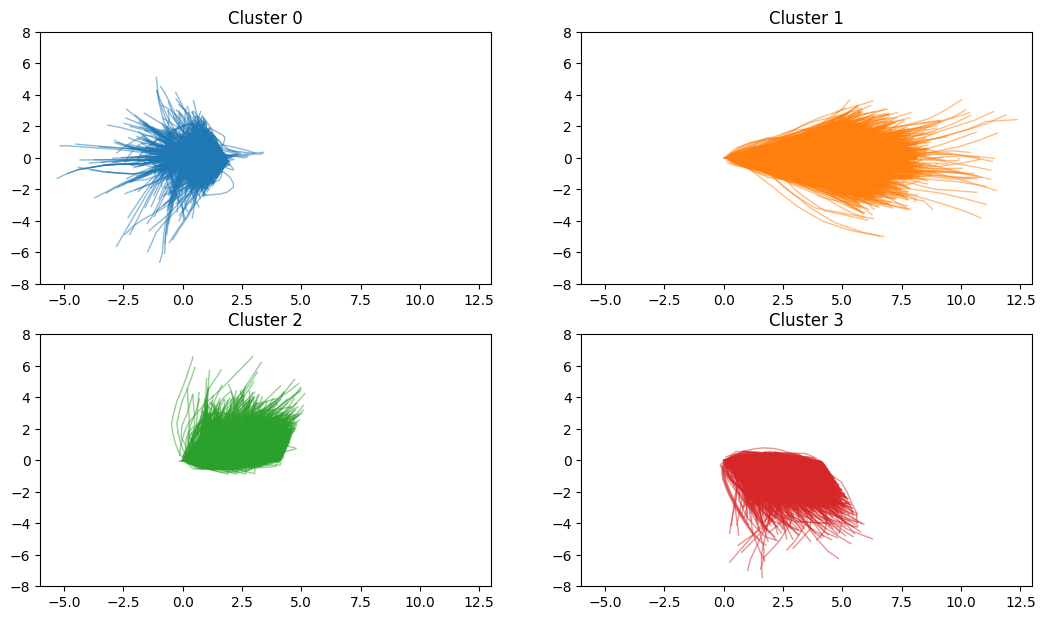

In [18]:
plot_cluster(sampled_trajs, cluster_lst, subplot=(2, 2))
# plot_cluster(sampled_trajs, cluster_lst, subplot=None)

cluster 0 is back, 1 is forward, 2 is left, 3 is right.

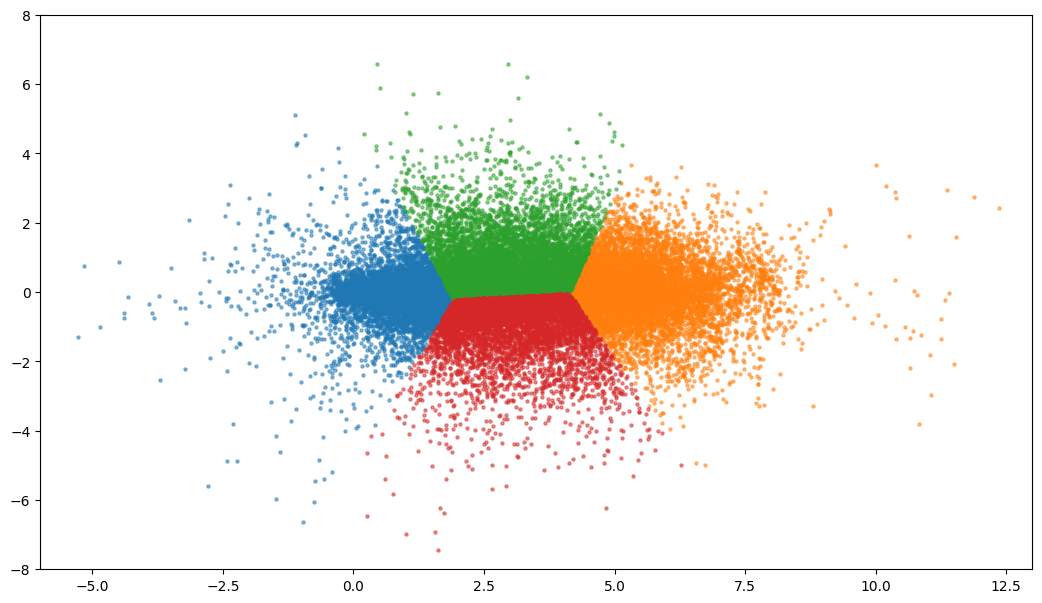

In [17]:
plot_cluster(sampled_trajs, cluster_lst, plot_curves=False)

In [24]:
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 'warn',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [22]:
# save cluster result
import pickle
import os
save_path = os.path.join(file_path,"cluster_result_4.pkl")
with open(save_path, 'wb') as f:
    pickle.dump(kmeans, f)

In [10]:
# load cluster result
import pickle
import os
save_path = os.path.join(file_path,"cluster_result_4.pkl")
with open(save_path, 'rb') as f:
    kmeans = pickle.load(f)

In [11]:
cluster_lst = kmeans.labels_
centers = kmeans.cluster_centers_

In [14]:
assert (kmeans.predict(sampled_trajs[:, :, -1]) == cluster_lst).all()
assert (kmeans.cluster_centers_ == centers).all()

In [15]:
from collections import Counter
Counter(cluster_lst)

Counter({1: 8413, 0: 14840, 2: 7469, 3: 5775})

# Hierarchical Cluster

How many clusters do we want?

left turn, right turn, quick straight, slow straight

if u-turn and standstill is necessary? 

In [43]:
deg = torch.rad2deg(torch.atan2(sampled_trajs[:,1,-1], sampled_trajs[:,0,-1]))

In [ ]:
# draw histogram of deg distribution
plt.hist(deg, bins=36,align='mid',rwidth=0.8)
plt.show()

In [ ]:
threshold_straight = 10
threshold_uturn = 90
idx_straight = torch.where(abs(deg)<threshold_straight)
idx_turn = torch.where((abs(deg)>=threshold_straight) * (abs(deg)<threshold_uturn))
idx_uturn = torch.where(abs(deg)>=threshold_uturn)

plt.plot(sampled_trajs[idx_straight][:,0,:].T, sampled_trajs[idx_straight][:,1,:].T, linewidth=1,color='blue',alpha=0.5)
plt.plot(sampled_trajs[idx_turn][:,0,:].T, sampled_trajs[idx_turn][:,1,:].T, linewidth=1,color='red',alpha=0.5)
plt.plot(sampled_trajs[idx_uturn][:,0,:].T, sampled_trajs[idx_uturn][:,1,:].T, linewidth=1,color='green',alpha=0.5)

plt.show()